<a href="https://colab.research.google.com/github/Matteo-Candi/ADM_HW2/blob/Matteo/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2 - ADM - group 17**

Description

In [1]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
locations = pd.read_csv('/content/drive/MyDrive/ADM/instagram_locations.csv', sep='\t')

In [ ]:
profiles = pd.read_csv('/content/drive/MyDrive/ADM/instagram_profiles.csv', sep='\t')

In [ ]:
posts = pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t')



--------------------------------------------------------------------------------

# Research Questions

## RQ1

## RQ2

count    3452771.00
mean         409.54
std         1041.94
min            0.00
25%           22.00
50%          120.00
75%          420.00
max       183730.00
Name: n_posts, dtype: float64 

There are: 1056815 NaN values


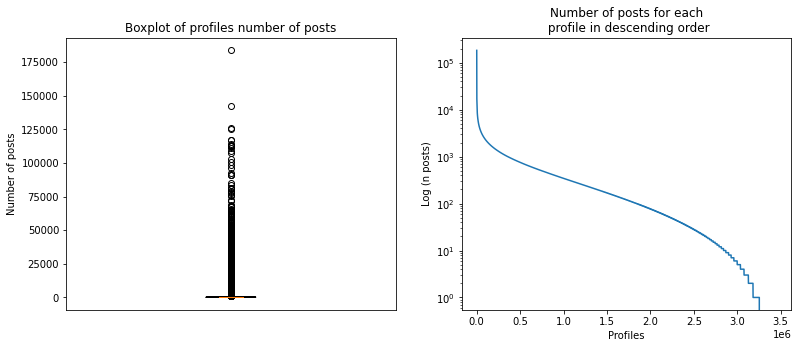

In [ ]:
# Plot the number of posts for each profile in descending order

print(round(profiles.n_posts.describe(),2), '\n')   # Returning the statistics it does not consider NaN values
print(f'There are: {profiles.n_posts.isna().sum()} NaN values')
n_posts = profiles.n_posts.dropna()
fig, axs = plt.subplots(1,2)
fig.set_size_inches(13, 5)

axs[0].boxplot(np.array(n_posts), 'b')
axs[0].set_xticks([])
axs[0].set(title='Boxplot of profiles number of posts', ylabel='Number of posts')

axs[1].plot(np.sort(n_posts)[::-1])
axs[1].set_title('Number of posts for each\n profile in descending order')
axs[1].set(ylabel='Log (n posts)', xlabel='Profiles', yscale='log')

plt.show()

In [ ]:
# What posts have the highest number of "likes"?

most_likes = pd.DataFrame(columns=['post_id', 'numbr_likes'])

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['post_id', 'numbr_likes']):
    chunk_most_like = chunk.sort_values(by='numbr_likes', ascending=False).head(5)
    most_likes = pd.concat([most_likes, chunk_most_like])

# To get all the rows we have to get one piece a time because the ram is not enough.
# After sorting this chunck we append the highest values of our variable in another dataframe
# with all the highest values. Than we return the highest of the highest.

print(most_likes.sort_values(by='numbr_likes', ascending=False).head(5))

              post_id numbr_likes
19624085  Bt3yaXmAM0d   8822952.0
19623988  BuwffB7g8cK   5447066.0
19624082  Buc1gyZAaMQ   5116398.0
19623986  BvcukE8AMuG   4271466.0
39701024  BqSLFVBFLfq     4264745


In [ ]:
# What posts have the most and the least number of comments?

most_comment = pd.DataFrame(columns=['post_id', 'number_comments'])
least_comment = pd.DataFrame(columns=['post_id', 'number_comments'])

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['post_id', 'number_comments']):
    chunk_most = chunk.sort_values(by='number_comments', ascending=False).head(5)
    chunk_least = chunk.sort_values(by='number_comments', ascending=False).tail(5)
    most_comment = pd.concat([most_comment, chunk_most])
    least_comment = pd.concat([least_comment, chunk_least])
  
print('Posts with most comments\n\n', most_comment.sort_values(by='number_comments', ascending=False).head(5))
print('\n\nPosts with least comments\n\n', least_comment.sort_values(by='number_comments', ascending=False).head(5))



Posts with most comments

               post_id number_comments
41873060  Bx2sPAjHviO          488953
12164781  BuGjhWAhAW5          313997
33261751  BJ-rkpTgn1N          257488
11149127  BMtisIxjhtT          214365
9383817   BzOOWj3DfZK          189888


Posts with least comments

               post_id number_comments
77497     BxhcazrhJVo               0
29752487  BwiS3P2h_sm               0
29752484  BwwhHRUganM               0
29499999  Bw4F7e-A3PB               0
29374405  BxWHjO0ntUC               0


Since the least number of comments in a post is 0, there are a lot posts with this value. Also checking the posts with 1 or 2 comments would be useless because for sure there are a lot. Differently the posts most comented are more interesting and show us the boarderline cases like the first that have almost 500k comments.

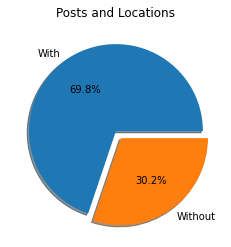

In [31]:
# How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results.

loc = 0
no_loc = 0

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['post_id', 'location_id']):
    no_loc += chunk.location_id.isna().sum()
    loc += 1

loc = (loc * 500000) - no_loc

plt.pie([loc, no_loc], labels=['With', 'Without'], shadow=True, explode=(0, .1),autopct='%1.1f%%')
plt.title('Posts and Locations')
plt.show()

In [24]:
# How many posts include only photos? How many also have videos?

n_photos = 0
n_multy = 0

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['post_id', 'post_type']):
    for el in chunk.post_type:
        if el == 1:
            n_photos +=1
        elif el == 3:
            n_multy += 1

print(f'There are {n_photos} posts that include only photos.')
print(f'There are {n_multy} posts that include also videos.')

There are 41534486 posts that include only photos.
There are 40943 posts that include also videos.


Proportion of NA in business_account variable: 0.24




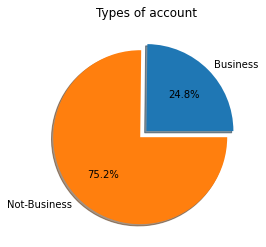

In [ ]:
# What's the percentage of business accounts vs non-business? What can you interpret regarding that percentage?

print(f"Proportion of NA in business_account variable: {round(profiles.is_business_account.isna().sum() / len(profiles.is_business_account), 2)}\n\n")
business = profiles.is_business_account.dropna()
t = sum(business)
f = len(business) - t

plt.pie([t,f], labels=['Business', 'Not-Business'], shadow=True, explode=(0, .1),autopct='%1.1f%%')
plt.title('Types of account')
plt.show()

## RQ3

## RQ4

## RQ5

## RQ6

## RQ7

## RQ8

## Bonus Points

--------------------------------------------------------------------------------

# Command Line Question

--------------------------------------------------------------------------------

# Algorithmic Question

## AQ1

In [ ]:
ciao

## AQ2